In [73]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import os
import pandas as pd
import numpy as np
import random
import cv2
import csv
import os, sys, time, datetime, random
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from skimage import io

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [74]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [75]:
def from_tsv_to_list(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter=";")

    expected = list(read_tsv)[0]
    
    return expected

In [76]:
# train
expected_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/expected.tsv')
in_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/in.tsv')

# val
expected_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/expected.tsv')
in_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/in.tsv')

# test
expected_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/expected.tsv')
in_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/in.tsv')

In [77]:
def show_random_img_with_all_annotations(in_list, expected_list, path_to_photos, matplotlib_colours_list, pages=5):
    for page in range(pages):
        random_img = random.randint(0,len(in_list))
        file_name = in_list[random_img]
        print(file_name)

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        annotations = expected_list[random_img].split(' ')
        for i in range(len(annotations)):
            bbox = annotations[i].split('/')[1]
            x0 = int(bbox.split(',')[0])
            y0 = int(bbox.split(',')[1])
            width = int(bbox.split(',')[2])
            height = int(bbox.split(',')[3])
            cat_id = int(annotations[i].split('/')[0])
            rect = matplotlib.patches.Rectangle(
                (x0, y0), 
                width, 
                height, 
                linewidth=1, 
                edgecolor=matplotlib_colours_list[cat_id], 
                facecolor='none'
            )
                
            ax.add_patch(rect)           
            ax.text(
                x0, 
                y0, 
                cat_id, 
                fontsize=8,
                backgroundcolor='black',
                color=matplotlib_colours_list[cat_id]
            )

        plt.show()

1373.jpg


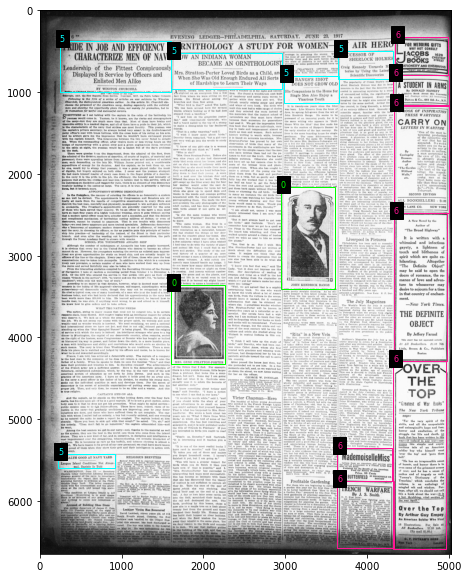

1229.jpg


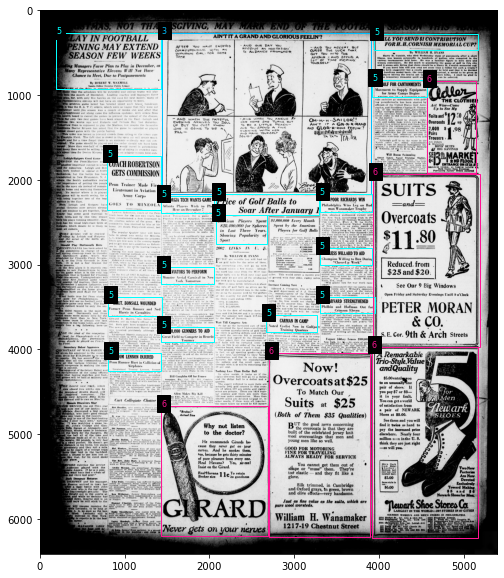

3065.jpg


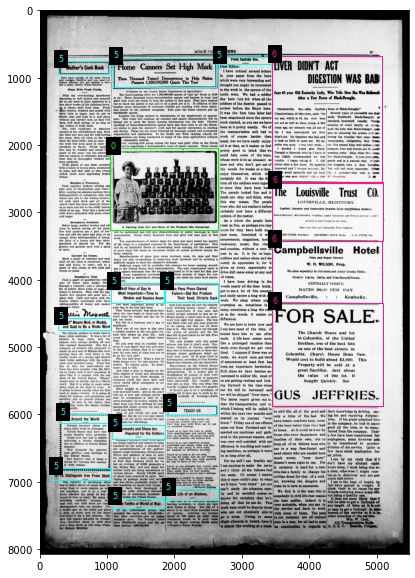

2658.jpg


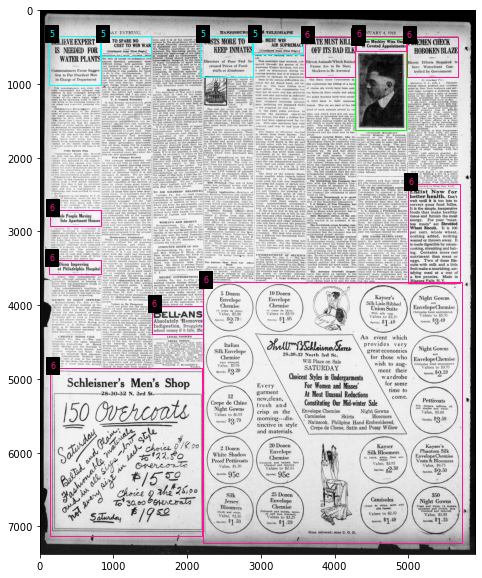

1036.jpg


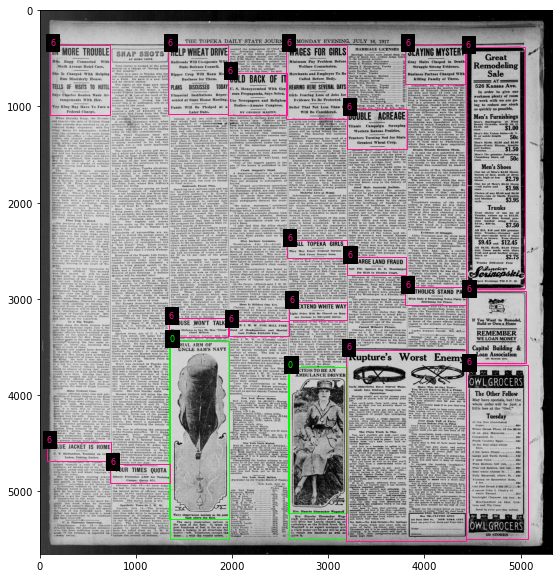

In [78]:
# some random images with annotations
show_random_img_with_all_annotations(
    in_train,
    expected_train,
    DIR_PATH+'scraped_photos_final/',
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
    5
)

In [79]:
def create_df(in_list, expected_list):
    df = pd.DataFrame()
    for i in tqdm(range(len(in_list))):
        expected_list_split = expected_list[i].split(' ')
        for ii in range(len(expected_list_split)):
            expected_list_split_2 = expected_list_split[ii].split('/')
            bbox = expected_list_split_2[1].split(',')
            temp_dict = {
                'file_name': in_list[i],
                'class': expected_list_split_2[0],
                'x0': int(bbox[0]),
                'y0': int(bbox[1]),
                'x1': int(bbox[0])+int(bbox[2]),
                'y1': int(bbox[1])+int(bbox[3]),
            }
            df = df.append(temp_dict, ignore_index=True)
            
    return df

In [80]:
# train
train_df = create_df(in_train, expected_train)

# val
val_df = create_df(in_val, expected_val)

# test
test_df = create_df(in_test, expected_test)

100%|██████████| 712/712 [00:20<00:00, 34.72it/s]


In [81]:
train_df

,file_name,class,x0,y0,x1,y1
0,1.jpg,0,3672.0,552.0,5298.0,2581.0
1,1.jpg,6,456.0,606.0,2832.0,2953.0
2,1.jpg,6,3684.0,576.0,5256.0,3055.0
3,1.jpg,6,2070.0,3007.0,2886.0,3721.0
4,1.jpg,6,2076.0,3704.0,2880.0,4328.0
...,...,...,...,...,...,...
35594,3560.jpg,5,2700.0,3354.0,3330.0,3582.0
35595,3560.jpg,5,3954.0,3342.0,4596.0,3828.0
35596,3560.jpg,5,3312.0,4188.0,3966.0,4596.0
35597,3560.jpg,5,2046.0,5028.0,2700.0,5364.0


In [82]:
class NewspapersDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations)
        

SyntaxError: invalid syntax (<ipython-input-82-325acad70f26>, line 10)

In [53]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/alexdrozdz/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [54]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from PIL import Image
from torchvision import transforms as T